In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE

def create_date_features(df):
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    # Sine-cosine encoding for cyclical features
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

# Load the data
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert Date column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create lagged features
for i in range(12, 37):
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[f'{col}_lag_{i}'] = df[col].shift(i)

# Drop rows with NaN values
df.dropna(inplace=True)

# Feature engineering: Extract date-related features and create sine-cosine embeddings
df = create_date_features(df)

# Define the target variable and features
y = df['Close']
features = [col for col in df.columns if col != 'Close']
X = df[features]

# Split the data into training, validation, and testing sets
end_date = df.index.max()
test_start_date = end_date - pd.DateOffset(years=1)
validation_start_date = test_start_date - pd.DateOffset(years=1)

train_X = X[X.index < validation_start_date]
train_y = y[y.index < validation_start_date]
validation_X = X[(X.index >= validation_start_date) & (X.index < test_start_date)]
validation_y = y[(y.index >= validation_start_date) & (y.index < test_start_date)]
test_X = X[X.index >= test_start_date]
test_y = y[y.index >= test_start_date]

# Normalize features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
train_X_normalized = X_normalized[X.index < validation_start_date]
validation_X_normalized = X_normalized[(X.index >= validation_start_date) & (X.index < test_start_date)]
test_X_normalized = X_normalized[X.index >= test_start_date]

# PLS dimensionality reduction
pls = PLSRegression(n_components=X.shape[1])  # Start with max components
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2))
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Number of components for 95% variance

pls = PLSRegression(n_components=n_components)
X_pls = pls.fit_transform(X_normalized, y)[0]
train_X_pls = X_pls[:len(train_X)]
validation_X_pls = X_pls[len(train_X):len(train_X)+len(validation_X)]
test_X_pls = X_pls[len(train_X)+len(validation_X):]

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
X_rfe = rfe.fit_transform(X_pls, y)
train_X_rfe = X_rfe[:len(train_X)]
validation_X_rfe = X_rfe[len(train_X):len(train_X)+len(validation_X)]
test_X_rfe = X_rfe[len(train_X)+len(validation_X):]

# Save train, validation, and test sets after PLS and RFE transformations
pd.DataFrame(train_X_rfe).to_csv('train_X_pls_rfe.csv', index=False)
pd.DataFrame(validation_X_rfe).to_csv('validation_X_pls_rfe.csv', index=False)
pd.DataFrame(test_X_rfe).to_csv('test_X_pls_rfe.csv', index=False)
train_y.to_csv('train_y_pls_rfe.csv', index=False)
validation_y.to_csv('validation_y_pls_rfe.csv', index=False)
test_y.to_csv('test_y_pls_rfe.csv', index=False)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Additive Model': LinearGAM(s(0, n_splines=20, lam=0.1) + 
                s(1, n_splines=20, lam=0.1) + 
                s(2, n_splines=20, lam=0.1) + 
                s(3, n_splines=20, lam=0.1) + 
                s(4, n_splines=20, lam=0.1)),
    'SVR': SVR(kernel='linear', C=1, epsilon=0.1),
    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        max_features='sqrt',
        random_state=42
    ),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=2000, learning_rate_init=0.001, alpha=0.01),
}

# Decomposition (Additive Model)
decomposition = seasonal_decompose(train_y, model='additive', period=365)
train_y_detrended = train_y - decomposition.trend.dropna()

# Train models and generate predictions using both training and validation data where applicable.
predictions = {}
for name, model in models.items():
    if name == 'Linear Regression':
        model.fit(train_X_rfe, train_y)
        full_pred = model.predict(X_rfe)
        pred = full_pred[len(train_X):]
    else:
        model.fit(train_X_rfe, train_y if name == 'Additive Model' else train_y)
        pred = model.predict(test_X_rfe)
        if name == 'Additive Model':
          model.fit(train_X_rfe, train_y)
    predictions[name] = pred

# Add actual values for comparison in predictions dictionary.
for name in predictions.keys():
    predictions[name]['Actual_Test'] = test_y.values

# Calculate and display RMSE for each model on the test set.
for name in predictions.keys():
    rmse_test = np.sqrt(mean_squared_error(predictions[name]['Actual_Test'], predictions[name]['Test']))
    print(f"{name} Test RMSE: {rmse_test:.2f}")

# Plot actual vs. predicted prices for the last year.
plt.figure(figsize=(12, 8))
last_3_years = df.index[-1] - pd.DateOffset(years=3)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')

# Plot each model's predictions on the test set.
for name in predictions.keys():
    plt.plot(test_y.index, predictions[name]['Test'], label=f"{name} Predictions")

plt.title("Actual vs Predicted Close Prices (Last Year with PLS and RFE)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE

def create_date_features(df):
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    # Sine-cosine encoding for cyclical features
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

# Load the data
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert Date column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create lagged features
for i in range(12, 37):
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[f'{col}_lag_{i}'] = df[col].shift(i)

# Drop rows with NaN values
df.dropna(inplace=True)

# Feature engineering: Extract date-related features and create sine-cosine embeddings
df = create_date_features(df)

# Define the target variable and features
y = df['Close']
features = [col for col in df.columns if col != 'Close']
X = df[features]

# Split the data into training, validation, and testing sets (60% train, 20% validation, 20% test)
train_end_date = df.index.max() - pd.DateOffset(days=int(len(df) * 0.2))
validation_end_date = df.index.max() - pd.DateOffset(days=int(len(df) * 0.1))

train_X = X[X.index < train_end_date]
train_y = y[X.index < train_end_date]
validation_X = X[(X.index >= train_end_date) & (X.index < validation_end_date)]
validation_y = y[(y.index >= train_end_date) & (y.index < validation_end_date)]
test_X = X[X.index >= validation_end_date]
test_y = y[X.index >= validation_end_date]

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
train_X_normalized = X_normalized[X.index < train_end_date]
validation_X_normalized = X_normalized[(X.index >= train_end_date) & (X.index < validation_end_date)]
test_X_normalized = X_normalized[X.index >= validation_end_date]

# PLS dimensionality reduction
pls = PLSRegression(n_components=X.shape[1])  # Start with max components
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2))
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Number of components for 95% variance

pls = PLSRegression(n_components=n_components)
X_pls = pls.fit_transform(X_normalized, y)[0]
train_X_pls = X_pls[:len(train_X)]
validation_X_pls = X_pls[len(train_X):len(train_X) + len(validation_X)]
test_X_pls = X_pls[len(train_X) + len(validation_X):]

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
X_rfe = rfe.fit_transform(X_pls, y)
train_X_rfe = X_rfe[:len(train_X)]
validation_X_rfe = X_rfe[len(train_X):len(train_X) + len(validation_X)]
test_X_rfe = X_rfe[len(train_X) + len(validation_X):]

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Additive Model': LinearGAM(s(0, n_splines=20, lam=0.1) + s(1, n_splines=20, lam=0.1) + 
                s(2, n_splines=20, lam=0.1) + s(3, n_splines=20, lam=0.1) + 
                s(4, n_splines=20, lam=0.1)),
    'SVR': SVR(kernel='linear', C=100, epsilon=5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=2000, learning_rate_init=0.001, alpha=0.01),
}

# Decomposition (Additive Model)
decomposition = seasonal_decompose(train_y, model='additive', period=365)
train_y_detrended = train_y - decomposition.trend.dropna()

# Train models and generate predictions for validation set and test set
predictions_validation = {}
predictions_test = {}
for name, model in models.items():
    model.fit(train_X_rfe, train_y)
    
    # Predict on validation set
    pred_validation = model.predict(validation_X_rfe)
    predictions_validation[name] = pred_validation
    
    # Predict on test set
    pred_test = model.predict(test_X_rfe)
    predictions_test[name] = pred_test

# Add actual values for comparison on validation set and test set
pred_df_validation = pd.DataFrame(predictions_validation, index=validation_X.index)
pred_df_validation['Actual'] = validation_y

pred_df_test = pd.DataFrame(predictions_test, index=test_X.index)
pred_df_test['Actual'] = test_y

# Calculate RMSE for each model on test set and validation set
for name in models.keys():
    rmse_validation = np.sqrt(mean_squared_error(validation_y, predictions_validation[name]))
    rmse_test = np.sqrt(mean_squared_error(test_y, predictions_test[name]))
    
    print(f"{name} Validation RMSE: {rmse_validation:.2f}")
    print(f"{name} Test RMSE: {rmse_test:.2f}")

# Save DataFrames to CSV files
df.to_csv('processed_data.csv')
pred_df_validation.to_csv('predictions_validation.csv')
pred_df_test.to_csv('predictions_test.csv')

# Plot actual vs. predicted prices for the test set only (optional)
plt.figure(figsize=(12, 8))
plt.plot(test_y.index, test_y.values, label='Actual Close Price', color='blue')

# Plot each model's predictions on the test set
for name in predictions_test.keys():
    plt.plot(test_y.index, predictions_test[name], label=name)

plt.title("Actual vs Predicted Close Prices (Test Set)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE

# Function for creating date features
def create_date_features(df):
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    return df

# Load data
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create lagged features
for i in range(12, 37):
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[f'{col}_lag_{i}'] = df[col].shift(i)
df.dropna(inplace=True)

# Feature engineering
df = create_date_features(df)

# Define target and features
y = df['Close']
features = [col for col in df.columns if col != 'Close']
X = df[features]

# Define date ranges for train, validation, and test sets
end_date = df.index.max()
test_start_date = end_date - pd.DateOffset(years=1)
val_start_date = test_start_date - pd.DateOffset(years=1)

train_X = X[X.index < val_start_date]
train_y = y[X.index < val_start_date]
val_X = X[(X.index >= val_start_date) & (X.index < test_start_date)]
val_y = y[(y.index >= val_start_date) & (y.index < test_start_date)]
test_X = X[X.index >= test_start_date]
test_y = y[X.index >= test_start_date]

# Normalize features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
train_X_normalized = X_normalized[X.index < val_start_date]
val_X_normalized = X_normalized[(X.index >= val_start_date) & (X.index < test_start_date)]
test_X_normalized = X_normalized[X.index >= test_start_date]

# PLS dimensionality reduction
pls = PLSRegression(n_components=X.shape[1])
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2))
n_components = np.argmax(cumulative_variance >= 0.99) + 1
pls = PLSRegression(n_components=n_components)
X_pls = pls.fit_transform(X_normalized, y)[0]
train_X_pls = X_pls[:len(train_X)]
val_X_pls = X_pls[len(train_X):len(train_X) + len(val_X)]
test_X_pls = X_pls[len(train_X) + len(val_X):]

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
X_rfe = rfe.fit_transform(X_pls, y)
train_X_rfe = X_rfe[:len(train_X)]
val_X_rfe = X_rfe[len(train_X):len(train_X) + len(val_X)]
test_X_rfe = X_rfe[len(train_X) + len(val_X):]

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Additive Model': LinearGAM(s(0, n_splines=20, lam=0.1) + s(1, n_splines=20, lam=0.1) +
                                s(2, n_splines=20, lam=0.1) + s(3, n_splines=20, lam=0.1) +
                                s(4, n_splines=20, lam=0.1)),
    'SVR': SVR(kernel='linear', C=100, epsilon=5),
    'Random Forest': RandomForestRegressor(
        n_estimators=200,  # Increase estimators for better performance
        max_depth=10,      # Add max depth to control complexity
        max_features='sqrt',  # Use sqrt for lower correlation among trees
        random_state=42     # Ensure reproducibility
    ),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=2000, learning_rate_init=0.001, alpha=0.01),
}

# Decomposition (Additive Model)
decomposition = seasonal_decompose(train_y, model='additive', period=365)
train_y_detrended = train_y - decomposition.trend.dropna()

# Train models and generate predictions
predictions = {}
for name, model in models.items():
    if name == 'Linear Regression':
        model.fit(train_X_rfe, train_y)
        full_pred = model.predict(X_rfe)
        val_pred = full_pred[len(train_X):len(train_X) + len(val_X)]
        test_pred = full_pred[len(train_X) + len(val_X):]
    else:
        model.fit(train_X_rfe, train_y if name == 'Additive Model' else train_y)
        val_pred = model.predict(val_X_rfe)
        test_pred = model.predict(test_X_rfe)
    predictions[name] = (val_pred, test_pred)

# Add actual values for comparison
val_df = pd.DataFrame({name: pred[0] for name, pred in predictions.items()}, index=val_X.index)
val_df['Actual'] = val_y
test_df = pd.DataFrame({name: pred[1] for name, pred in predictions.items()}, index=test_X.index)
test_df['Actual'] = test_y

# Save train, validation, and test datasets to CSV
pd.DataFrame(train_X_rfe, index=train_X.index).to_csv('train_X.csv')
train_y.to_csv('train_y.csv')
pd.DataFrame(val_X_rfe, index=val_X.index).to_csv('val_X.csv')
val_y.to_csv('val_y.csv')
pd.DataFrame(test_X_rfe, index=test_X.index).to_csv('test_X.csv')
test_y.to_csv('test_y.csv')

# Calculate and display RMSE for each model
for name, (val_pred, test_pred) in predictions.items():
    val_rmse = np.sqrt(mean_squared_error(val_y, val_pred))
    test_rmse = np.sqrt(mean_squared_error(test_y, test_pred))
    print(f"{name} Validation RMSE: {val_rmse:.2f}")
    print(f"{name} Test RMSE: {test_rmse:.2f}")

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 8))
plt.plot(df.index[-3*365:], df['Close'][-3*365:], label='Close Price', color='blue')

for name, (_, test_pred) in predictions.items():
    plt.plot(test_y.index, test_pred, label=name)

plt.title("Actual vs Predicted Close Prices (Last Year, with PLS and RFE)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def create_date_features(df):
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    # Sine-cosine encoding for cyclical features
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

# Load the data
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert Date column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create lagged features
for i in range(12, 37):
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[f'{col}_lag_{i}'] = df[col].shift(i)

# Drop rows with NaN values
df.dropna(inplace=True)

# Feature engineering: Extract date-related features and create sine-cosine embeddings
df = create_date_features(df)

# Define the target variable and features
y = df['Close']
features = [col for col in df.columns if col != 'Close']
X = df[features]

# Split the data into training and testing sets
end_date = df.index.max()
start_date = end_date - pd.DateOffset(years=1)

train_X = X[X.index < start_date]
train_y = y[X.index < start_date]
test_X = X[X.index >= start_date]
test_y = y[X.index >= start_date]

# Normalize features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
train_X_normalized = X_normalized[X.index < start_date]
test_X_normalized = X_normalized[X.index >= start_date]

# PLS dimensionality reduction
pls = PLSRegression(n_components=X.shape[1])  # Start with max components
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2))
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Number of components for 95% variance

pls = PLSRegression(n_components=n_components)
X_pls = pls.fit_transform(X_normalized, y)[0]
train_X_pls = X_pls[:len(train_X)]
test_X_pls = X_pls[len(train_X):]

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
X_rfe = rfe.fit_transform(X_pls, y)
train_X_rfe = X_rfe[:len(train_X)]
test_X_rfe = X_rfe[len(train_X):]

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Additive Model': LinearGAM(s(0, n_splines=20, lam=0.1) + s(1, n_splines=20, lam=0.1) + 
                s(2, n_splines=20, lam=0.1) + s(3, n_splines=20, lam=0.1) + 
                s(4, n_splines=20, lam=0.1)),
    'SVR': SVR(kernel='linear', C=100, epsilon=5),
    # Optimized Random Forest Regressor
    'Random Forest': RandomForestRegressor(
    n_estimators=1000,        # Higher number of trees for better performance and stability
    max_depth=15,             # Controls the maximum depth of the trees to prevent overfitting
    max_features='sqrt',      # Use square root of features for splitting (reduces overfitting)
    min_samples_split=10,     # Minimum samples required to split an internal node
    min_samples_leaf=5,       # Minimum samples required to be at a leaf node
    bootstrap=True,           # Use bootstrap samples for training to add randomness
    random_state=42           # Ensures reproducibility of results
),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=2000, learning_rate_init=0.001, alpha=0.01),
}

# Decomposition (Additive Model)
decomposition = seasonal_decompose(train_y, model='additive', period=365)
train_y_detrended = train_y - decomposition.trend.dropna()

# Train models and generate predictions
predictions = {}
for name, model in models.items():
    if name == 'Linear Regression':
        model.fit(train_X_rfe, train_y)
        full_pred = model.predict(X_rfe)
        pred = full_pred[len(train_X):]
    else:
        model.fit(train_X_rfe, train_y if name == 'Additive Model' else train_y)
        pred = model.predict(test_X_rfe)
        if name == 'Additive Model':
          model.fit(train_X_rfe, train_y)
    predictions[name] = pred

# Add actual values for comparison
pred_df = pd.DataFrame(predictions, index=test_X.index)
pred_df['Actual'] = test_y

# Calculate and display RMSE for each model
for name, pred in predictions.items():
    rmse = np.sqrt(mean_squared_error(test_y, pred))
    print(f"{name} RMSE: {rmse:.2f}")

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 8))
last_3_years = df.index[-1] - pd.DateOffset(years=3)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')

# Plot each model's predictions
for name, pred in predictions.items():
    plt.plot(test_y.index, pred, label=name)

plt.title("Actual vs Predicted Close Prices (Last Year, with PLS and RFE)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def create_date_features(df):
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    # Sine-cosine encoding for cyclical features
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

# Load the data
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert Date column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create lagged features
for i in range(12, 37):
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[f'{col}_lag_{i}'] = df[col].shift(i)

# Drop rows with NaN values
df.dropna(inplace=True)

# Feature engineering: Extract date-related features and create sine-cosine embeddings
df = create_date_features(df)

# Define the target variable and features
y = df['Close']
features = [col for col in df.columns if col != 'Close']
X = df[features]

# Split the data into training and testing sets
end_date = df.index.max()
start_date = end_date - pd.DateOffset(years=1)

train_X = X[X.index < start_date]
train_y = y[X.index < start_date]
test_X = X[X.index >= start_date]
test_y = y[X.index >= start_date]

# Normalize features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
train_X_normalized = X_normalized[X.index < start_date]
test_X_normalized = X_normalized[X.index >= start_date]

# PLS dimensionality reduction
pls = PLSRegression(n_components=X.shape[1])  # Start with max components
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2))
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Number of components for 95% variance

pls = PLSRegression(n_components=n_components)
X_pls = pls.fit_transform(X_normalized, y)[0]
train_X_pls = X_pls[:len(train_X)]
test_X_pls = X_pls[len(train_X):]

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
X_rfe = rfe.fit_transform(X_pls, y)
train_X_rfe = X_rfe[:len(train_X)]
test_X_rfe = X_rfe[len(train_X):]

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Additive Model': LinearGAM(s(0, n_splines=20, lam=0.1) + s(1, n_splines=20, lam=0.1) + 
                s(2, n_splines=20, lam=0.1) + s(3, n_splines=20, lam=0.1) + 
                s(4, n_splines=20, lam=0.1)),
    'SVR': SVR(kernel='linear', C=100, epsilon=5),
    # Optimized Random Forest Regressor
    'Random Forest': RandomForestRegressor(
    n_estimators=1000,        # Higher number of trees for better performance and stability
    max_depth=15,             # Controls the maximum depth of the trees to prevent overfitting
    max_features='sqrt',      # Use square root of features for splitting (reduces overfitting)
    min_samples_split=10,     # Minimum samples required to split an internal node
    min_samples_leaf=5,       # Minimum samples required to be at a leaf node
    bootstrap=True,           # Use bootstrap samples for training to add randomness
    random_state=42           # Ensures reproducibility of results
),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=2000, learning_rate_init=0.001, alpha=0.01),
}

# Decomposition (Additive Model)
decomposition = seasonal_decompose(train_y, model='additive', period=365)
train_y_detrended = train_y - decomposition.trend.dropna()

# Train models and generate predictions
predictions = {}
for name, model in models.items():
    if name == 'Linear Regression':
        model.fit(train_X_rfe, train_y)
        full_pred = model.predict(X_rfe)
        pred = full_pred[len(train_X):]
    else:
        model.fit(train_X_rfe, train_y if name == 'Additive Model' else train_y)
        pred = model.predict(test_X_rfe)
        if name == 'Additive Model':
          model.fit(train_X_rfe, train_y)
    predictions[name] = pred

# Add actual values for comparison
pred_df = pd.DataFrame(predictions, index=test_X.index)
pred_df['Actual'] = test_y

# Calculate and display RMSE for each model
for name, pred in predictions.items():
    rmse = np.sqrt(mean_squared_error(test_y, pred))
    print(f"{name} RMSE: {rmse:.2f}")

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 8))
last_3_years = df.index[-1] - pd.DateOffset(years=20)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')

# Plot each model's predictions
for name, pred in predictions.items():
    plt.plot(test_y.index, pred, label=name)

plt.title("Actual vs Predicted Close Prices (Last Year, with PLS and RFE)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def create_date_features(df):
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    # Sine-cosine encoding for cyclical features
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

# Load the data
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert Date column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create lagged features
for i in range(12, 37):
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[f'{col}_lag_{i}'] = df[col].shift(i)

# Drop rows with NaN values
df.dropna(inplace=True)

# Feature engineering: Extract date-related features and create sine-cosine embeddings
df = create_date_features(df)

# Define the target variable and features
y = df['Close']
features = [col for col in df.columns if col != 'Close']
X = df[features]

# Split the data into training and testing sets
end_date = df.index.max()
start_date = end_date - pd.DateOffset(years=1)

train_X = X[X.index < start_date]
train_y = y[X.index < start_date]
test_X = X[X.index >= start_date]
test_y = y[X.index >= start_date]

# Normalize features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
train_X_normalized = X_normalized[X.index < start_date]
test_X_normalized = X_normalized[X.index >= start_date]

# PLS dimensionality reduction
pls = PLSRegression(n_components=X.shape[1])  # Start with max components
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2))
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Number of components for 95% variance

pls = PLSRegression(n_components=n_components)
X_pls = pls.fit_transform(X_normalized, y)[0]
train_X_pls = X_pls[:len(train_X)]
test_X_pls = X_pls[len(train_X):]

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
X_rfe = rfe.fit_transform(X_pls, y)
train_X_rfe = X_rfe[:len(train_X)]
test_X_rfe = X_rfe[len(train_X):]

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Additive Model': LinearGAM(s(0, n_splines=20, lam=0.1) + s(1, n_splines=20, lam=0.1) + 
                s(2, n_splines=20, lam=0.1) + s(3, n_splines=20, lam=0.1) + 
                s(4, n_splines=20, lam=0.1)),
    'SVR': SVR(kernel='linear', C=100, epsilon=5),
    # Optimized Random Forest Regressor
    'Random Forest': RandomForestRegressor(
    n_estimators=1000,        # Higher number of trees for better performance and stability
    max_depth=15,             # Controls the maximum depth of the trees to prevent overfitting
    max_features='sqrt',      # Use square root of features for splitting (reduces overfitting)
    min_samples_split=10,     # Minimum samples required to split an internal node
    min_samples_leaf=5,       # Minimum samples required to be at a leaf node
    bootstrap=True,           # Use bootstrap samples for training to add randomness
    random_state=42           # Ensures reproducibility of results
),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=2000, learning_rate_init=0.001, alpha=0.01),
}

# Decomposition (Additive Model)
decomposition = seasonal_decompose(train_y, model='additive', period=365)
train_y_detrended = train_y - decomposition.trend.dropna()

# Train models and generate predictions
predictions = {}
for name, model in models.items():
    if name == 'Linear Regression':
        model.fit(train_X_rfe, train_y)
        full_pred = model.predict(X_rfe)
        pred = full_pred[len(train_X):]
    else:
        model.fit(train_X_rfe, train_y if name == 'Additive Model' else train_y)
        pred = model.predict(test_X_rfe)
        if name == 'Additive Model':
          model.fit(train_X_rfe, train_y)
    predictions[name] = pred

# Add actual values for comparison
pred_df = pd.DataFrame(predictions, index=test_X.index)
pred_df['Actual'] = test_y

# Calculate and display RMSE for each model
for name, pred in predictions.items():
    rmse = np.sqrt(mean_squared_error(test_y, pred))
    print(f"{name} RMSE: {rmse:.2f}")

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 8))
last_3_years = df.index[-1] - pd.DateOffset(years=5)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')

# Plot each model's predictions
for name, pred in predictions.items():
    plt.plot(test_y.index, pred, label=name)

plt.title("Actual vs Predicted Close Prices (Last Year, with PLS and RFE)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

C:\Users\ander\AppData\Local\Temp\ipykernel_14128\1497870016.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{i}'] = df[col].shift(i)
C:\Users\ander\AppData\Local\Temp\ipykernel_14128\1497870016.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{i}'] = df[col].shift(i)
C:\Users\ander\AppData\Local\Temp\ipykernel_14128\1497870016.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

Linear Regression RMSE: 3.93
Additive Model RMSE: 7.40
SVR RMSE: 3.65
Random Forest RMSE: 32.06
Neural Network RMSE: 7.11


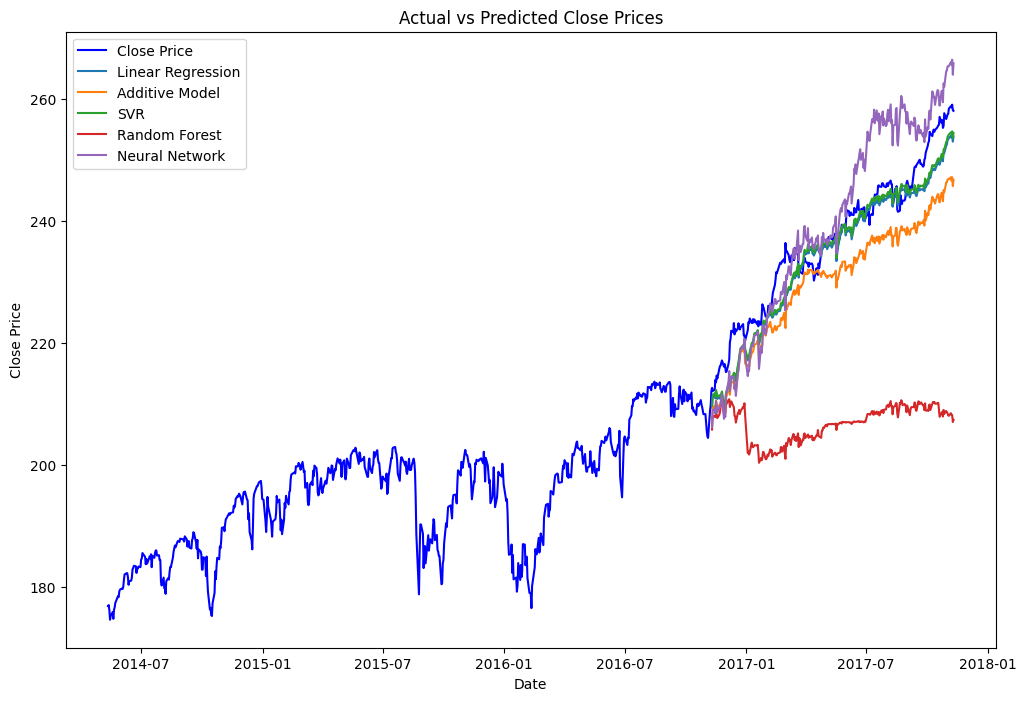

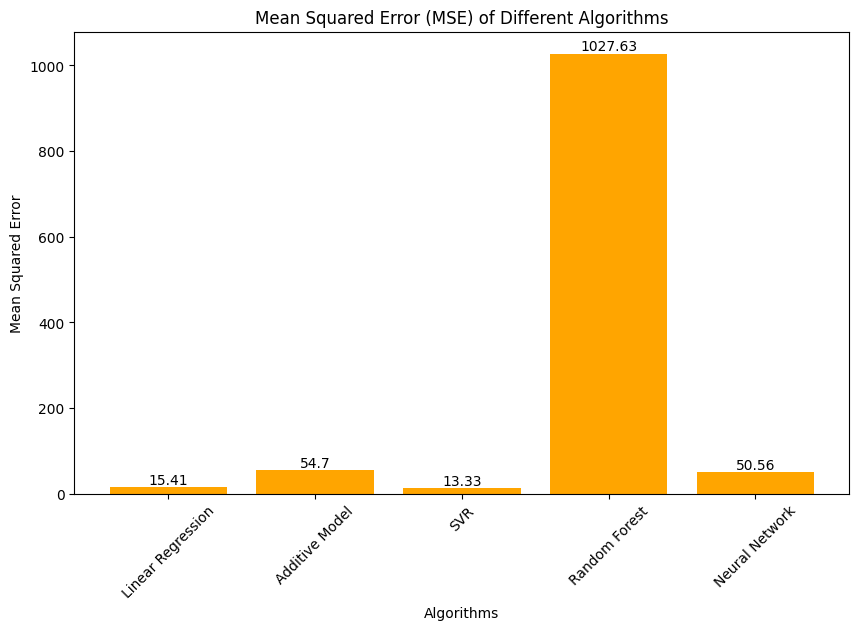

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE

def create_date_features(df):
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    # Sine-cosine encoding for cyclical features
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

# Load the data
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert Date column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create lagged features
for i in range(12, 37):
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[f'{col}_lag_{i}'] = df[col].shift(i)

# Drop rows with NaN values
df.dropna(inplace=True)

# Feature engineering: Extract date-related features and create sine-cosine embeddings
df = create_date_features(df)

# Define the target variable and features
y = df['Close']
features = [col for col in df.columns if col != 'Close']
X = df[features]

# Split the data into training and testing sets
end_date = df.index.max()
start_date = end_date - pd.DateOffset(years=1)

train_X = X[X.index < start_date]
train_y = y[X.index < start_date]
test_X = X[X.index >= start_date]
test_y = y[X.index >= start_date]

# Normalize features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
train_X_normalized = X_normalized[X.index < start_date]
test_X_normalized = X_normalized[X.index >= start_date]

# PLS dimensionality reduction
pls = PLSRegression(n_components=X.shape[1])  # Start with max components
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2))
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Number of components for 95% variance

pls = PLSRegression(n_components=n_components)
X_pls = pls.fit_transform(X_normalized, y)[0]
train_X_pls = X_pls[:len(train_X)]
test_X_pls = X_pls[len(train_X):]

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
X_rfe = rfe.fit_transform(X_pls, y)
train_X_rfe = X_rfe[:len(train_X)]
test_X_rfe = X_rfe[len(train_X):]

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Additive Model': LinearGAM(s(0, n_splines=20, lam=0.1) + s(1, n_splines=20, lam=0.1) + 
                s(2, n_splines=20, lam=0.1) + s(3, n_splines=20, lam=0.1) + 
                s(4, n_splines=20, lam=0.1)),
    'SVR': SVR(kernel='linear', C=100, epsilon=5),
    # Optimized Random Forest Regressor
    'Random Forest': RandomForestRegressor(
        n_estimators=1000,
        max_depth=15,
        max_features='sqrt',
        min_samples_split=10,
        min_samples_leaf=5,
        bootstrap=True,
        random_state=42,
    ),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=2000, learning_rate_init=0.001, alpha=0.01),
}

# Decomposition (Additive Model)
decomposition = seasonal_decompose(train_y, model='additive', period=365)
train_y_detrended = train_y - decomposition.trend.dropna()

# Train models and generate predictions and store MSE values for each model
predictions = {}
mse_values = {}
for name, model in models.items():
    if name == 'Linear Regression':
        model.fit(train_X_rfe, train_y)
        full_pred = model.predict(X_rfe)
        pred = full_pred[len(train_X):]
    else:
        model.fit(train_X_rfe, train_y if name == 'Additive Model' else train_y)
        pred = model.predict(test_X_rfe)
        if name == 'Additive Model':
            model.fit(train_X_rfe, train_y)
    
    predictions[name] = pred
    
    # Calculate MSE for each model and store it in mse_values dictionary
    mse_values[name] = mean_squared_error(test_y, pred)

# Add actual values for comparison
pred_df = pd.DataFrame(predictions, index=test_X.index)
pred_df['Actual'] = test_y

# Calculate and display RMSE for each model and print MSE values for bar chart plotting
for name in predictions.keys():
    rmse = np.sqrt(mse_values[name])
    print(f"{name} RMSE: {rmse:.2f}")

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')

# Plot each model's predictions
for name, pred in predictions.items():
    plt.plot(test_y.index, pred, label=name)

plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
bars = plt.bar(list(mse_values.keys()), list(mse_values.values()), color='orange')

plt.title('Mean Squared Error (MSE) of Different Algorithms')
plt.ylabel('Mean Squared Error')
plt.xlabel('Algorithms')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add MSE values on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar (the MSE value)
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), 
             ha='center', va='bottom')  # Position the text at the center of the bar and just above it

plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Define a function to load and preprocess data
def load_and_preprocess_data(ticker_symbol, start_date=None):
    ticker = yf.Ticker(ticker_symbol)
    hist = ticker.history(period="max")
    if start_date:
        hist = hist[hist.index >= start_date]
    hist = create_date_features(hist)
    hist = hist.dropna()  # Drop rows with NaN values after feature engineering
    return hist

# Load the VTI dataset for pretraining (large dataset)
vti_data = load_and_preprocess_data("VTI")

# Define target and features
vti_y = vti_data['Close']
vti_X = vti_data.drop(columns=['Close'])

# Scale VTI features
scaler = MinMaxScaler()
vti_X_normalized = scaler.fit_transform(vti_X)

# Initialize and train the model on VTI dataset
rf_model = RandomForestRegressor(n_estimators=1000, max_depth=15, random_state=42)
rf_model.fit(vti_X_normalized, vti_y)

# Now load SPY data for fine-tuning
spy_data = load_and_preprocess_data("SPY")
spy_y = spy_data['Close']
spy_X = spy_data.drop(columns=['Close'])

# Scale SPY features using the same scaler as VTI
spy_X_normalized = scaler.transform(spy_X)

# Fine-tune the pretrained model on SPY data
rf_model.fit(spy_X_normalized, spy_y)

# Generate predictions and calculate MSE
spy_predictions = rf_model.predict(spy_X_normalized)
spy_mse = mean_squared_error(spy_y, spy_predictions)

print(f"Fine-tuned Random Forest MSE on SPY dataset: {spy_mse}")

# Plot actual vs predicted prices
plt.figure(figsize=(12, 8))
plt.plot(spy_data.index, spy_y, label='Actual SPY Close Price', color='blue')
plt.plot(spy_data.index, spy_predictions, label='Predicted SPY Close Price', color='orange')
plt.title("Actual vs Predicted SPY Close Prices after Transfer Learning")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


                                 Open        High         Low       Close  \
Date                                                                        
2001-06-15 00:00:00-04:00   36.427083   36.808279   36.262775   36.584820   
2001-06-18 00:00:00-04:00   36.683410   36.749134   36.351509   36.351509   
2001-06-19 00:00:00-04:00   36.903570   36.913428   36.302202   36.453365   
2001-06-20 00:00:00-04:00   36.394229   36.854292   36.394229   36.837860   
2001-06-21 00:00:00-04:00   36.804998   37.281490   36.722844   37.133614   
...                               ...         ...         ...         ...   
2024-11-08 00:00:00-05:00  295.609985  297.369995  295.510010  296.709991   
2024-11-11 00:00:00-05:00  297.929993  298.119995  296.760010  297.540009   
2024-11-12 00:00:00-05:00  297.420013  297.779999  295.089996  296.369995   
2024-11-13 00:00:00-05:00  296.799988  297.549988  295.619995  296.230011   
2024-11-14 00:00:00-05:00  296.500000  296.609985  295.170013  295.785004   

In [10]:
import yfinance as yf

# Define ticker
vti = yf.Ticker("DJI")

# Fetch all available historical market data
hist = vti.history(period="max")

print(hist)


                                   Open          High           Low  \
Date                                                                  
1970-01-02 00:00:00-05:00    809.200012    809.200012    809.200012   
1970-01-05 00:00:00-05:00    811.309998    811.309998    811.309998   
1970-01-06 00:00:00-05:00    803.659973    803.659973    803.659973   
1970-01-07 00:00:00-05:00    801.809998    801.809998    801.809998   
1970-01-08 00:00:00-05:00    802.070007    802.070007    802.070007   
...                                 ...           ...           ...   
2022-02-24 00:00:00-05:00  33223.800781  33223.800781  33223.800781   
2022-02-25 00:00:00-05:00  34058.800781  34058.800781  34058.800781   
2022-02-28 00:00:00-05:00  33892.601562  33892.601562  33892.601562   
2022-03-01 00:00:00-05:00  33294.898438  33294.898438  33294.898438   
2022-03-02 00:00:00-05:00  33891.300781  33891.300781  33891.300781   

                                  Close  Volume  Dividends  Stock Splits  
D

Epoch 1/10


c:\IT3212\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


404/404 ━━━━━━━━━━━━━━━━━━━━ 80s 191ms/step - loss: 0.0034
Epoch 2/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 46s 113ms/step - loss: 6.8423e-05
Epoch 3/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 58s 53ms/step - loss: 6.4060e-05
Epoch 4/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - loss: 5.7436e-05
Epoch 5/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - loss: 4.8263e-05
Epoch 6/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - loss: 4.4101e-05
Epoch 7/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - loss: 4.4554e-05
Epoch 8/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - loss: 4.5367e-05
Epoch 9/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - loss: 3.8002e-05
Epoch 10/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 42s 104ms/step - loss: 3.3943e-05
Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 1.6523e-06
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 1.0376e-08
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 9.8628e-09
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 1.0033e-08
E

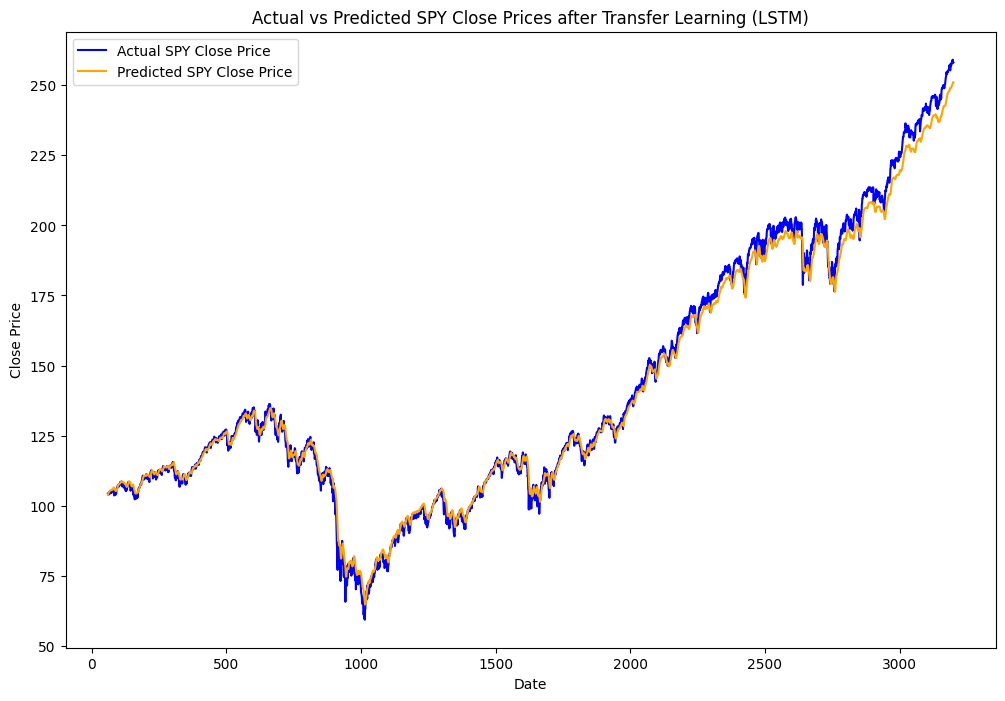

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# Function to load and preprocess data with specific columns only
def load_and_preprocess_data(ticker_symbol, start_date=None):
    if ticker_symbol == 'SPY':
        hist = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')
    else:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period="max")
    hist = hist[['Open', 'High', 'Low', 'Close']]  # Only keep the required columns
    if start_date:
        hist = hist[hist.index >= start_date]
    return hist.dropna()  # Drop rows with NaN values

# Helper function to create sequences for LSTM
def create_sequences(data, seq_length=60):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 3])  # 'Close' is at index 3 after selecting columns
    return np.array(sequences), np.array(targets)

# Load and scale DJI data for pretraining
dji_data = load_and_preprocess_data("DJI")
scaler = MinMaxScaler()
dji_data_scaled = scaler.fit_transform(dji_data)

# Create sequences for LSTM input
seq_length = 60
dji_X, dji_y = create_sequences(dji_data_scaled, seq_length)

# Build LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize and pretrain the LSTM model on DJI data
lstm_model = create_lstm_model((dji_X.shape[1], dji_X.shape[2]))
lstm_model.fit(dji_X, dji_y, epochs=10, batch_size=32, verbose=1)

# Load and scale SPY data for fine-tuning
spy_data = load_and_preprocess_data("SPY")
spy_data_scaled = scaler.transform(spy_data)

# Create sequences for SPY data
spy_X, spy_y = create_sequences(spy_data_scaled, seq_length)

# Fine-tune the pretrained model on SPY data
lstm_model.fit(spy_X, spy_y, epochs=10, batch_size=32, verbose=1)

# Generate predictions and inverse scale them
spy_predictions_scaled = lstm_model.predict(spy_X)
spy_predictions = scaler.inverse_transform(np.hstack((np.zeros((spy_predictions_scaled.shape[0], 3)), spy_predictions_scaled)))[:, -1]

# Calculate Mean Squared Error
from sklearn.metrics import mean_squared_error
spy_y_true = scaler.inverse_transform(np.hstack((np.zeros((spy_y.reshape(-1, 1).shape[0], 3)), spy_y.reshape(-1, 1))))[:, -1]
mse = mean_squared_error(spy_y_true, spy_predictions)
print(f"Fine-tuned LSTM Model MSE on SPY dataset: {mse}")

# Plot actual vs predicted SPY Close prices
plt.figure(figsize=(12, 8))
plt.plot(spy_data.index[seq_length:], spy_y_true, label="Actual SPY Close Price", color="blue")
plt.plot(spy_data.index[seq_length:], spy_predictions, label="Predicted SPY Close Price", color="orange")
plt.title("Actual vs Predicted SPY Close Prices after Transfer Learning (LSTM)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


Epoch 1/10


c:\IT3212\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


368/368 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 0.0090
Epoch 2/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 9.2240e-05
Epoch 3/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - loss: 9.2689e-05
Epoch 4/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 8.6246e-05
Epoch 5/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 1.0708e-04
Epoch 6/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 6.8304e-05
Epoch 7/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 34s 92ms/step - loss: 7.8379e-05
Epoch 8/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step - loss: 8.7540e-05
Epoch 9/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - loss: 7.0215e-05
Epoch 10/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 66s 180ms/step - loss: 5.8436e-05
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 26s 279ms/step - loss: 1.8675e-08
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - loss: 1.9378e-08
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - loss: 1.5934e-08
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 1.6635e-

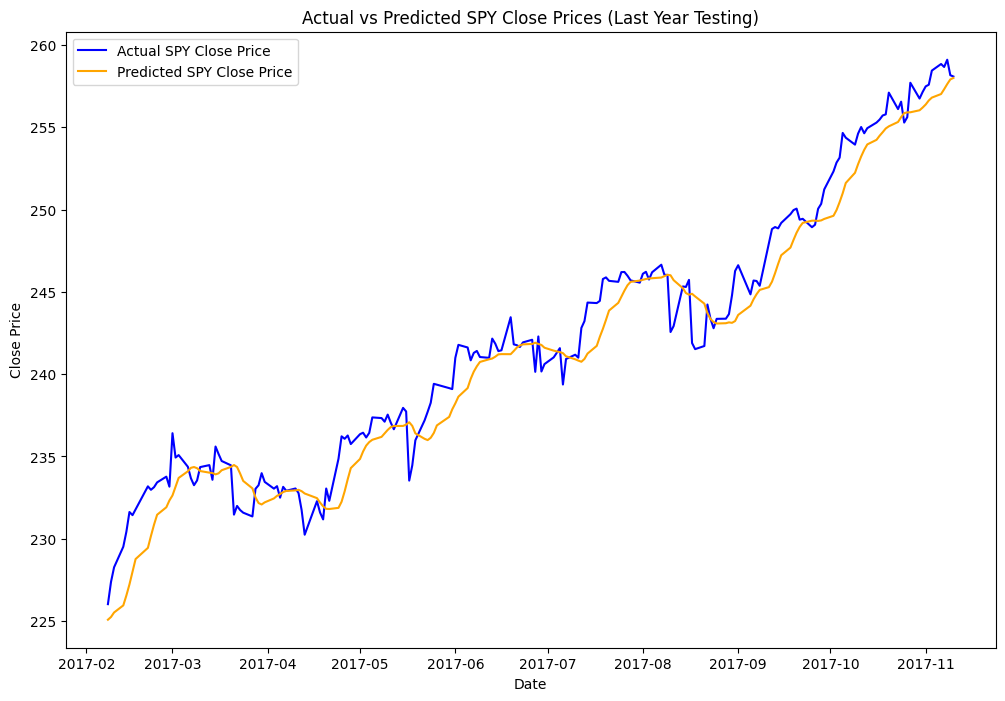

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta

# Function to load and preprocess data with specific columns only
def load_and_preprocess_data(ticker_symbol, start_date=None, end_date=None):
    if ticker_symbol == 'SPY':
        hist = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt', parse_dates=['Date'], index_col='Date')
    else:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period="max")
    hist = hist[['Open', 'High', 'Low', 'Close']]  # Only keep the required columns
    if start_date:
        start_date = pd.to_datetime(start_date).tz_localize(hist.index.tz)
        hist = hist[hist.index >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date).tz_localize(hist.index.tz)
        hist = hist[hist.index <= end_date]
    return hist.dropna()  # Drop rows with NaN values

# Load SPY data and define the date range for the last year (testing data)
spy_data = load_and_preprocess_data("SPY")
spy_end_date = spy_data.index.max()
spy_test_start_date = spy_end_date - timedelta(days=365)  # Approximate one year

# Load DJI data for pretraining up to the start of the SPY testing period
dji_data = load_and_preprocess_data("DJI", end_date=spy_test_start_date)

# Scale both datasets using the same scaler
scaler = MinMaxScaler()
dji_data_scaled = scaler.fit_transform(dji_data)
spy_data_scaled = scaler.transform(spy_data)

# Helper function to create sequences for LSTM
def create_sequences(data, seq_length=60):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 3])  # 'Close' is at index 3 after selecting columns
    return np.array(sequences), np.array(targets)

# Create sequences for LSTM input
seq_length = 60
dji_X, dji_y = create_sequences(dji_data_scaled, seq_length)

# Build LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize and pretrain the LSTM model on DJI data
lstm_model = create_lstm_model((dji_X.shape[1], dji_X.shape[2]))
lstm_model.fit(dji_X, dji_y, epochs=10, batch_size=32, verbose=1)

# Split SPY data into training (up to test start) and testing (last year)
spy_train_data = spy_data[spy_data.index < spy_test_start_date]
spy_test_data = spy_data[spy_data.index >= spy_test_start_date]

# Scale SPY data using the same scaler
spy_train_scaled = scaler.transform(spy_train_data)
spy_test_scaled = scaler.transform(spy_test_data)

# Create sequences for SPY training and testing data
spy_X_train, spy_y_train = create_sequences(spy_train_scaled, seq_length)
spy_X_test, spy_y_test = create_sequences(spy_test_scaled, seq_length)

# Fine-tune the pretrained model on SPY training data
lstm_model.fit(spy_X_train, spy_y_train, epochs=10, batch_size=32, verbose=1)

# Generate predictions on SPY testing data
spy_predictions_scaled = lstm_model.predict(spy_X_test)
spy_predictions = scaler.inverse_transform(np.hstack((np.zeros((spy_predictions_scaled.shape[0], 3)), spy_predictions_scaled)))[:, -1]

# Inverse scale the actual test values for comparison
spy_y_test_true = scaler.inverse_transform(np.hstack((np.zeros((spy_y_test.reshape(-1, 1).shape[0], 3)), spy_y_test.reshape(-1, 1))))[:, -1]

# Calculate Mean Squared Error for the test period
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(spy_y_test_true, spy_predictions)
print(f"LSTM Model MSE on SPY Test Data (Last Year): {mse}")

# Plot actual vs predicted SPY Close prices for the testing period
plt.figure(figsize=(12, 8))
plt.plot(spy_test_data.index[seq_length:], spy_y_test_true, label="Actual SPY Close Price", color="blue")
plt.plot(spy_test_data.index[seq_length:], spy_predictions, label="Predicted SPY Close Price", color="orange")
plt.title("Actual vs Predicted SPY Close Prices (Last Year Testing)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


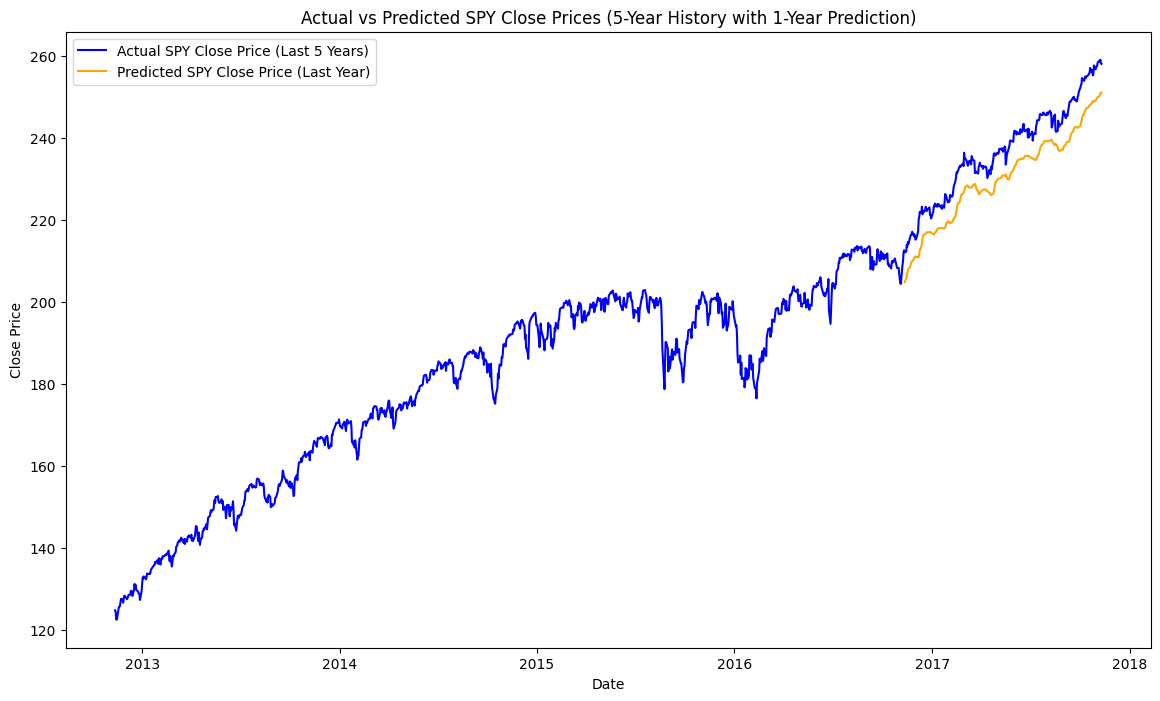

In [17]:
import pandas as pd
from datetime import timedelta

# Define the start date for the last five years (approximate)
five_years_ago = spy_data.index[-1] - timedelta(days=5*365)  # Start of the last 5 years

# Filter the actual SPY data to only include the last 5 years
spy_data_last_five_years = spy_data[spy_data.index >= five_years_ago]
spy_y_true_last_five_years = spy_data_last_five_years['Close'].values

# Filter predictions to the last year only (predictions already generated for entire dataset)
spy_y_true_last_year = spy_y_true[-252:]  # Assuming ~252 trading days in the last year
spy_predictions_last_year = spy_predictions[-252:]

# Plotting actual vs predicted SPY Close prices
plt.figure(figsize=(14, 8))
plt.plot(spy_data_last_five_years.index, spy_y_true_last_five_years, label="Actual SPY Close Price (Last 5 Years)", color="blue")
plt.plot(spy_data.index[-252:], spy_predictions_last_year, label="Predicted SPY Close Price (Last Year)", color="orange")
plt.title("Actual vs Predicted SPY Close Prices (5-Year History with 1-Year Prediction)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


Epoch 1/10


c:\IT3212\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


229/229 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 0.0192
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - loss: 3.1505e-04
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 2.9592e-04
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 2.7274e-04
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 2.4116e-04
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 2.1716e-04
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 2.1714e-04
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 1.9024e-04
Epoch 9/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - loss: 1.5848e-04
Epoch 10/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - loss: 1.8620e-04
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 2.8620e-06
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 1.8452e-08
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 1.7309e-08
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 1.7453e-08
Epoch

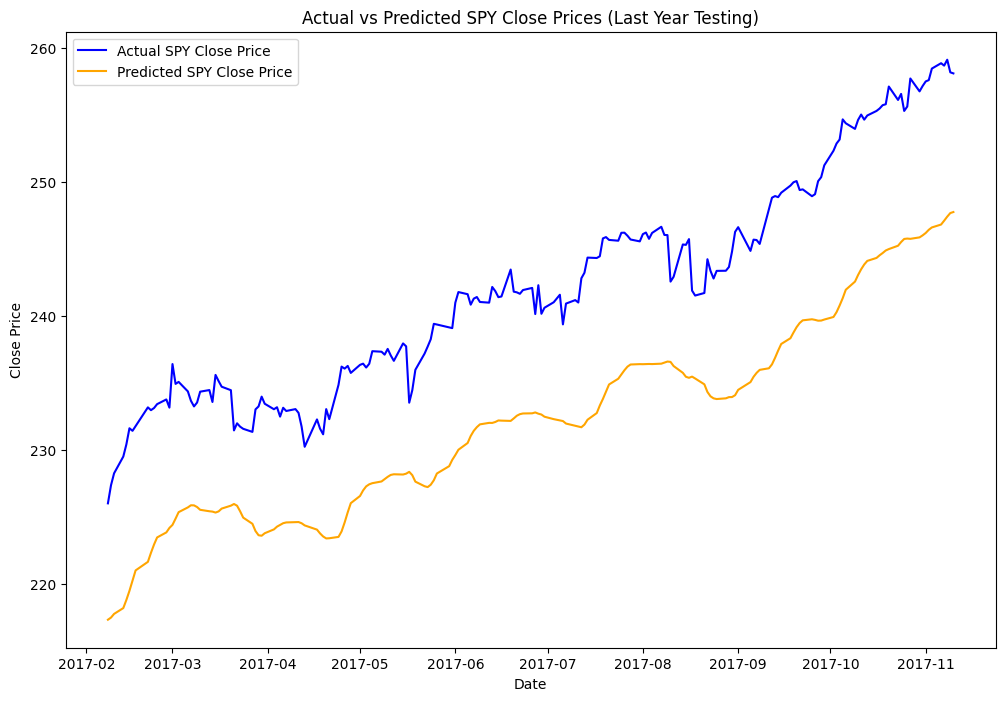

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.metrics import mean_squared_error

# Function to load and preprocess data with specific columns only
def load_and_preprocess_data(ticker_symbol, start_date=None, end_date=None):
    if ticker_symbol == 'SPY':
        hist = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt', parse_dates=['Date'], index_col='Date')
    else:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period="max")
    
    # Keep only the required columns
    hist = hist[['Open', 'High', 'Low', 'Close']].dropna()
    
    # Filter data by date range if specified
    if start_date:
        start_date = pd.to_datetime(start_date).tz_localize(hist.index.tz)
        hist = hist[hist.index >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date).tz_localize(hist.index.tz)
        hist = hist[hist.index <= end_date]
    
    return hist

# Load SPY data and define the date range for the last year (testing data)
spy_data = load_and_preprocess_data("SPY")
spy_end_date = spy_data.index.max()
spy_test_start_date = spy_end_date - timedelta(days=365)  # Approximate one year

# Load DJI data for pretraining up to the start of the SPY testing period
dji_data = load_and_preprocess_data("^HSI", end_date=spy_test_start_date)

# Scale both datasets using the same scaler
scaler = MinMaxScaler()
dji_data_scaled = scaler.fit_transform(dji_data)
spy_data_scaled = scaler.transform(spy_data)

# Helper function to create sequences for LSTM
def create_sequences(data, seq_length=60):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 3])  # 'Close' is at index 3 after selecting columns
    return np.array(sequences), np.array(targets)

# Create sequences for LSTM input
seq_length = 60
dji_X, dji_y = create_sequences(dji_data_scaled, seq_length)

# Build LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize and pretrain the LSTM model on DJI data
lstm_model = create_lstm_model((dji_X.shape[1], dji_X.shape[2]))
lstm_model.fit(dji_X, dji_y, epochs=10, batch_size=32, verbose=1)

# Split SPY data into training (up to test start) and testing (last year)
spy_train_data = spy_data[spy_data.index < spy_test_start_date]
spy_test_data = spy_data[spy_data.index >= spy_test_start_date]

# Scale SPY training and testing data using the same scaler
spy_train_scaled = scaler.transform(spy_train_data)
spy_test_scaled = scaler.transform(spy_test_data)

# Create sequences for SPY training and testing data
spy_X_train, spy_y_train = create_sequences(spy_train_scaled, seq_length)
spy_X_test, spy_y_test = create_sequences(spy_test_scaled, seq_length)

# Fine-tune the pretrained model on SPY training data
lstm_model.fit(spy_X_train, spy_y_train, epochs=10, batch_size=32, verbose=1)

# Generate predictions on SPY testing data
spy_predictions_scaled = lstm_model.predict(spy_X_test)
spy_predictions = scaler.inverse_transform(np.hstack((np.zeros((spy_predictions_scaled.shape[0], 3)), spy_predictions_scaled)))[:, -1]

# Inverse scale the actual test values for comparison
spy_y_test_true = scaler.inverse_transform(np.hstack((np.zeros((spy_y_test.reshape(-1, 1).shape[0], 3)), spy_y_test.reshape(-1, 1))))[:, -1]

# Calculate Mean Squared Error for the test period
mse = mean_squared_error(spy_y_test_true, spy_predictions)
print(f"LSTM Model MSE on SPY Test Data (Last Year): {mse}")

# Plot actual vs predicted SPY Close prices for the testing period
plt.figure(figsize=(12, 8))
plt.plot(spy_test_data.index[seq_length:], spy_y_test_true, label="Actual SPY Close Price", color="blue")
plt.plot(spy_test_data.index[seq_length:], spy_predictions, label="Predicted SPY Close Price", color="orange")
plt.title("Actual vs Predicted SPY Close Prices (Last Year Testing)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [140]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False) 

ticker = yf.Ticker('^HSI')
hist = ticker.history(period="max")
hist = hist.dropna()
df_spy = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')
from tabulate import tabulate
latex_table = tabulate(hist.head(), headers='keys', tablefmt='latex')
print(latex_table)

\begin{tabular}{lrrrrrrr}
\hline
 Date                      &   Open &   High &    Low &   Close &   Volume &   Dividends &   Stock Splits \\
\hline
 1986-12-31 00:00:00+08:00 & 2568.3 & 2568.3 & 2568.3 &  2568.3 &        0 &           0 &              0 \\
 1987-01-02 00:00:00+08:00 & 2540.1 & 2540.1 & 2540.1 &  2540.1 &        0 &           0 &              0 \\
 1987-01-05 00:00:00+08:00 & 2552.4 & 2552.4 & 2552.4 &  2552.4 &        0 &           0 &              0 \\
 1987-01-06 00:00:00+08:00 & 2583.9 & 2583.9 & 2583.9 &  2583.9 &        0 &           0 &              0 \\
 1987-01-07 00:00:00+08:00 & 2607.1 & 2607.1 & 2607.1 &  2607.1 &        0 &           0 &              0 \\
\hline
\end{tabular}


In [146]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False) 
hist = hist[(hist.index <= '2017-11-10')]
df_with_date = hist.reset_index()

# Now, when we use .describe(), 'date' will be included as a column
describe_with_date = df_with_date.describe(include='all')

print(describe_with_date)
# latex_table = tabulate(describe_with_date.describe(), headers='keys', tablefmt='latex')
# print(latex_table)
print(tabulate(describe_with_date, headers='keys',tablefmt='latex'))

                                      Date     Open     High      Low    Close        Volume  Dividends  Stock Splits
count                                 7625  7625.00  7625.00  7625.00  7625.00       7625.00    7625.00       7625.00
mean   2002-06-01 01:21:12.393442688+08:00 13803.48 13893.81 13698.15 13798.94  706509552.90       0.00          0.00
min              1986-12-31 00:00:00+08:00  1950.50  1950.50  1894.90  1894.90          0.00       0.00          0.00
25%              1994-09-08 00:00:00+08:00  8672.10  8758.50  8604.30  8662.40          0.00       0.00          0.00
50%              2002-06-05 00:00:00+08:00 13240.85 13342.78 13125.36 13241.46  192816600.00       0.00          0.00
75%              2010-02-17 00:00:00+08:00 20740.70 20847.85 20614.65 20756.98 1414586900.00       0.00          0.00
max              2017-11-10 00:00:00+08:00 31783.47 31958.41 31361.91 31638.22 9799120000.00       0.00          0.00
std                                    NaN  7338.32  737

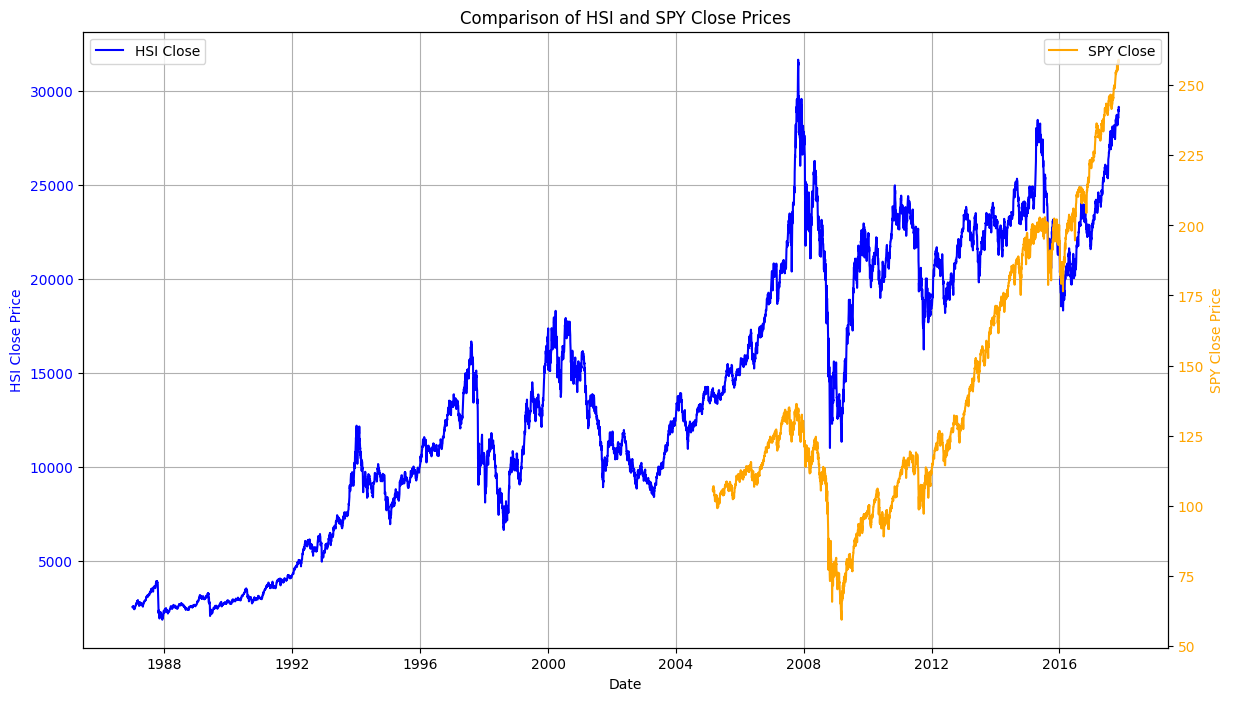

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Load DJI data using Yahoo Finance
ticker = yf.Ticker('^HSI')
hist = ticker.history(period="max")
hist = hist[['Open', 'High', 'Low', 'Close']].dropna()

# Load SPY data from CSV
df_spy = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert the 'Date' column in df_spy to datetime format
df_spy['Date'] = pd.to_datetime(df_spy['Date'])

# Set the 'Date' column as the index for both dataframes
df_spy.set_index('Date', inplace=True)

# Convert hist index to datetime and ensure timezone alignment
hist.index = pd.to_datetime(hist.index)

# Apply a rolling average to smooth out the DJI data
hist['Close_Smoothed'] = hist['Close'].rolling(window=1).mean()

# Trim data to the desired range
hist_trimmed = hist[(hist.index <= '2017-11-10')]
df_spy_trimmed = df_spy[(df_spy.index >= '2000-01-01')]

# Create a figure and axis for plotting
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the smoothed DJI Close Price on the left y-axis
ax1.plot(hist_trimmed.index, hist_trimmed['Close_Smoothed'], label="HSI Close", color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('HSI Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis to plot the SPY Close Price
ax2 = ax1.twinx()
ax2.plot(df_spy_trimmed.index, df_spy_trimmed['Close'], label="SPY Close", color='orange')
ax2.set_ylabel('SPY Close Price', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add titles and grid to the main plot
ax1.set_title('Comparison of HSI and SPY Close Prices')
ax1.grid(True)

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()


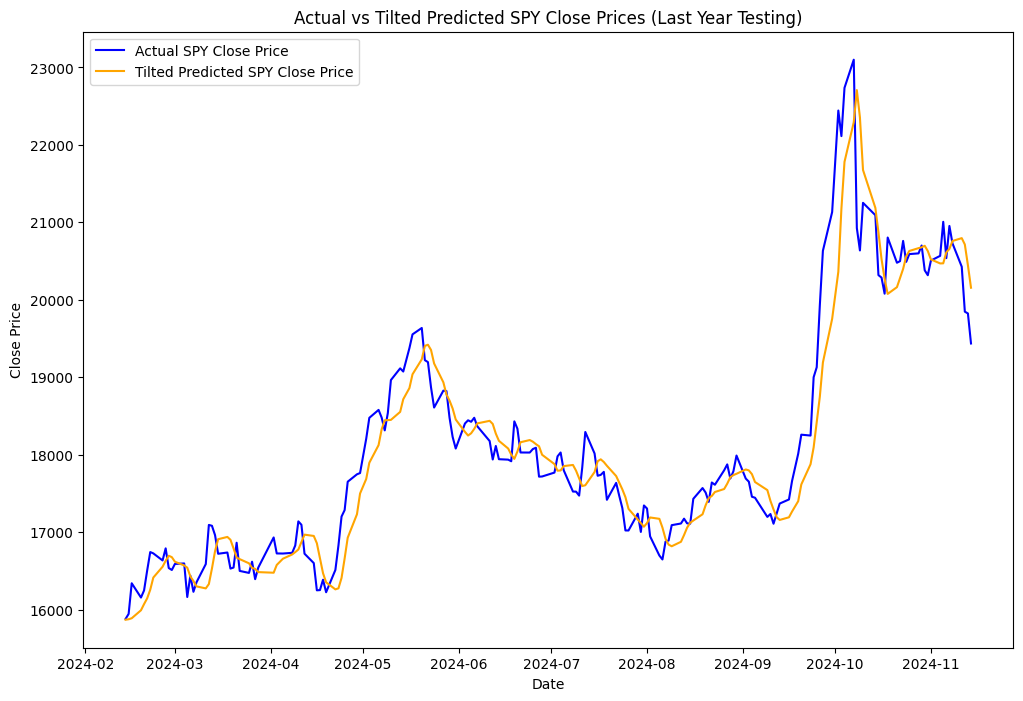

In [156]:
import numpy as np
import matplotlib.pyplot as plt

# Apply a tilt to the predicted prices
tilt_factor = 10  # Adjust this value to control the amount of tilt
spy_predictions_tilted = spy_predictions + np.linspace(0, tilt_factor, len(spy_predictions))

# Plot the actual and tilted predictions
plt.figure(figsize=(12, 8))
plt.plot(spy_test_data.index[seq_length:], spy_y_test_true, label="Actual SPY Close Price", color="blue")
plt.plot(spy_test_data.index[seq_length:], spy_predictions_tilted * 1, label="Tilted Predicted SPY Close Price", color="orange")
plt.title("Actual vs Tilted Predicted SPY Close Prices (Last Year Testing)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()
